<a href="https://colab.research.google.com/github/GunarsA/LU-VT/blob/main/LU_VT_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Valodu tehnoloģijas Md1 - Gunārs Ābeltiņš ga22008


In [ ]:
!pip install hfst
import hfst
from IPython.display import Image

In [ ]:
import sys

def hfst2png(transducer, png_name):
    # Write the FST to a file using the att format
    f = open("a.att", "w", encoding="utf-8")
    transducer.minimize()
    transducer.write_att(f, False)

    # Convert the FST file to the dot format
    # dot format is used by graphviz library for graph visualization
    f = open("a.att", "r", encoding="utf-8")
    with open("graph.dot", "w", encoding="utf-8") as out_f:
        out_f.write('digraph G { rankdir="LR"\n')
        out_f.write('node [fontname="Tahoma",shape=circle,fontsize=14,fixedsize=true,fillcolor="grey",style=filled]\n')
        out_f.write('edge [fontname="FreeMono",fontsize=14]\n')
        for line in f.readlines():
            line = line.strip()
            row = line.split('\t')
            if len(row) >= 4:
                out_f.write('%s [label="%s"];\n' % (row[0], row[0]))
                out_f.write('%s -> %s [label="%s:%s"];\n' % (row[0], row[1], row[2], row[3]))
            elif len(row) == 1: # Final state
                out_f.write('%s [label="%s",shape=doublecircle];\n' % (row[0], row[0]))
        out_f.write('}')

    # Call graphviz dot function to generate a png file from dot file
    !dot -Tpng graph.dot > $png_name

## Leksikona izveide

Leksikona veido:
1. Saraksts ar vairāksimbolu virknēm, ko izmanto FST aprakstīta morfoloģija (Multichar_Symbols)
2. Sakņu/celmu/morfēmu leksikons (LEXICON)
3. Morfotaktika (piemērā LEXICON N4dekl)

Simbols "!" tiek lietots kā komentāra simbols

```
Multichar_Symbols
        +N      ! Noun tag
        +Sg     ! Singular
        +Pl     ! Plural
        +Nom
        +Gen
        +Dat
        +Acc
        +Loc

!Define root lexicon
LEXICON Root
  Nouns ; ! No input, no output

!Define noun lexicon
LEXICON Nouns
  rok N4dekl ;

! Define 4th declension paradigm
LEXICON N4dekl
+N+Sg+Nom:^a  # ;
+N+Sg+Gen:^as # ;
+N+Sg+Dat:^ai # ;
+N+Sg+Acc:^u # ;
+N+Sg+Loc:^ā # ;
+N+Pl+Nom:^as  # ;
+N+Pl+Gen:^u  # ;
+N+Pl+Dat:^ām # ;
+N+Pl+Acc:^as # ;
+N+Pl+Loc:^ās # ;

```



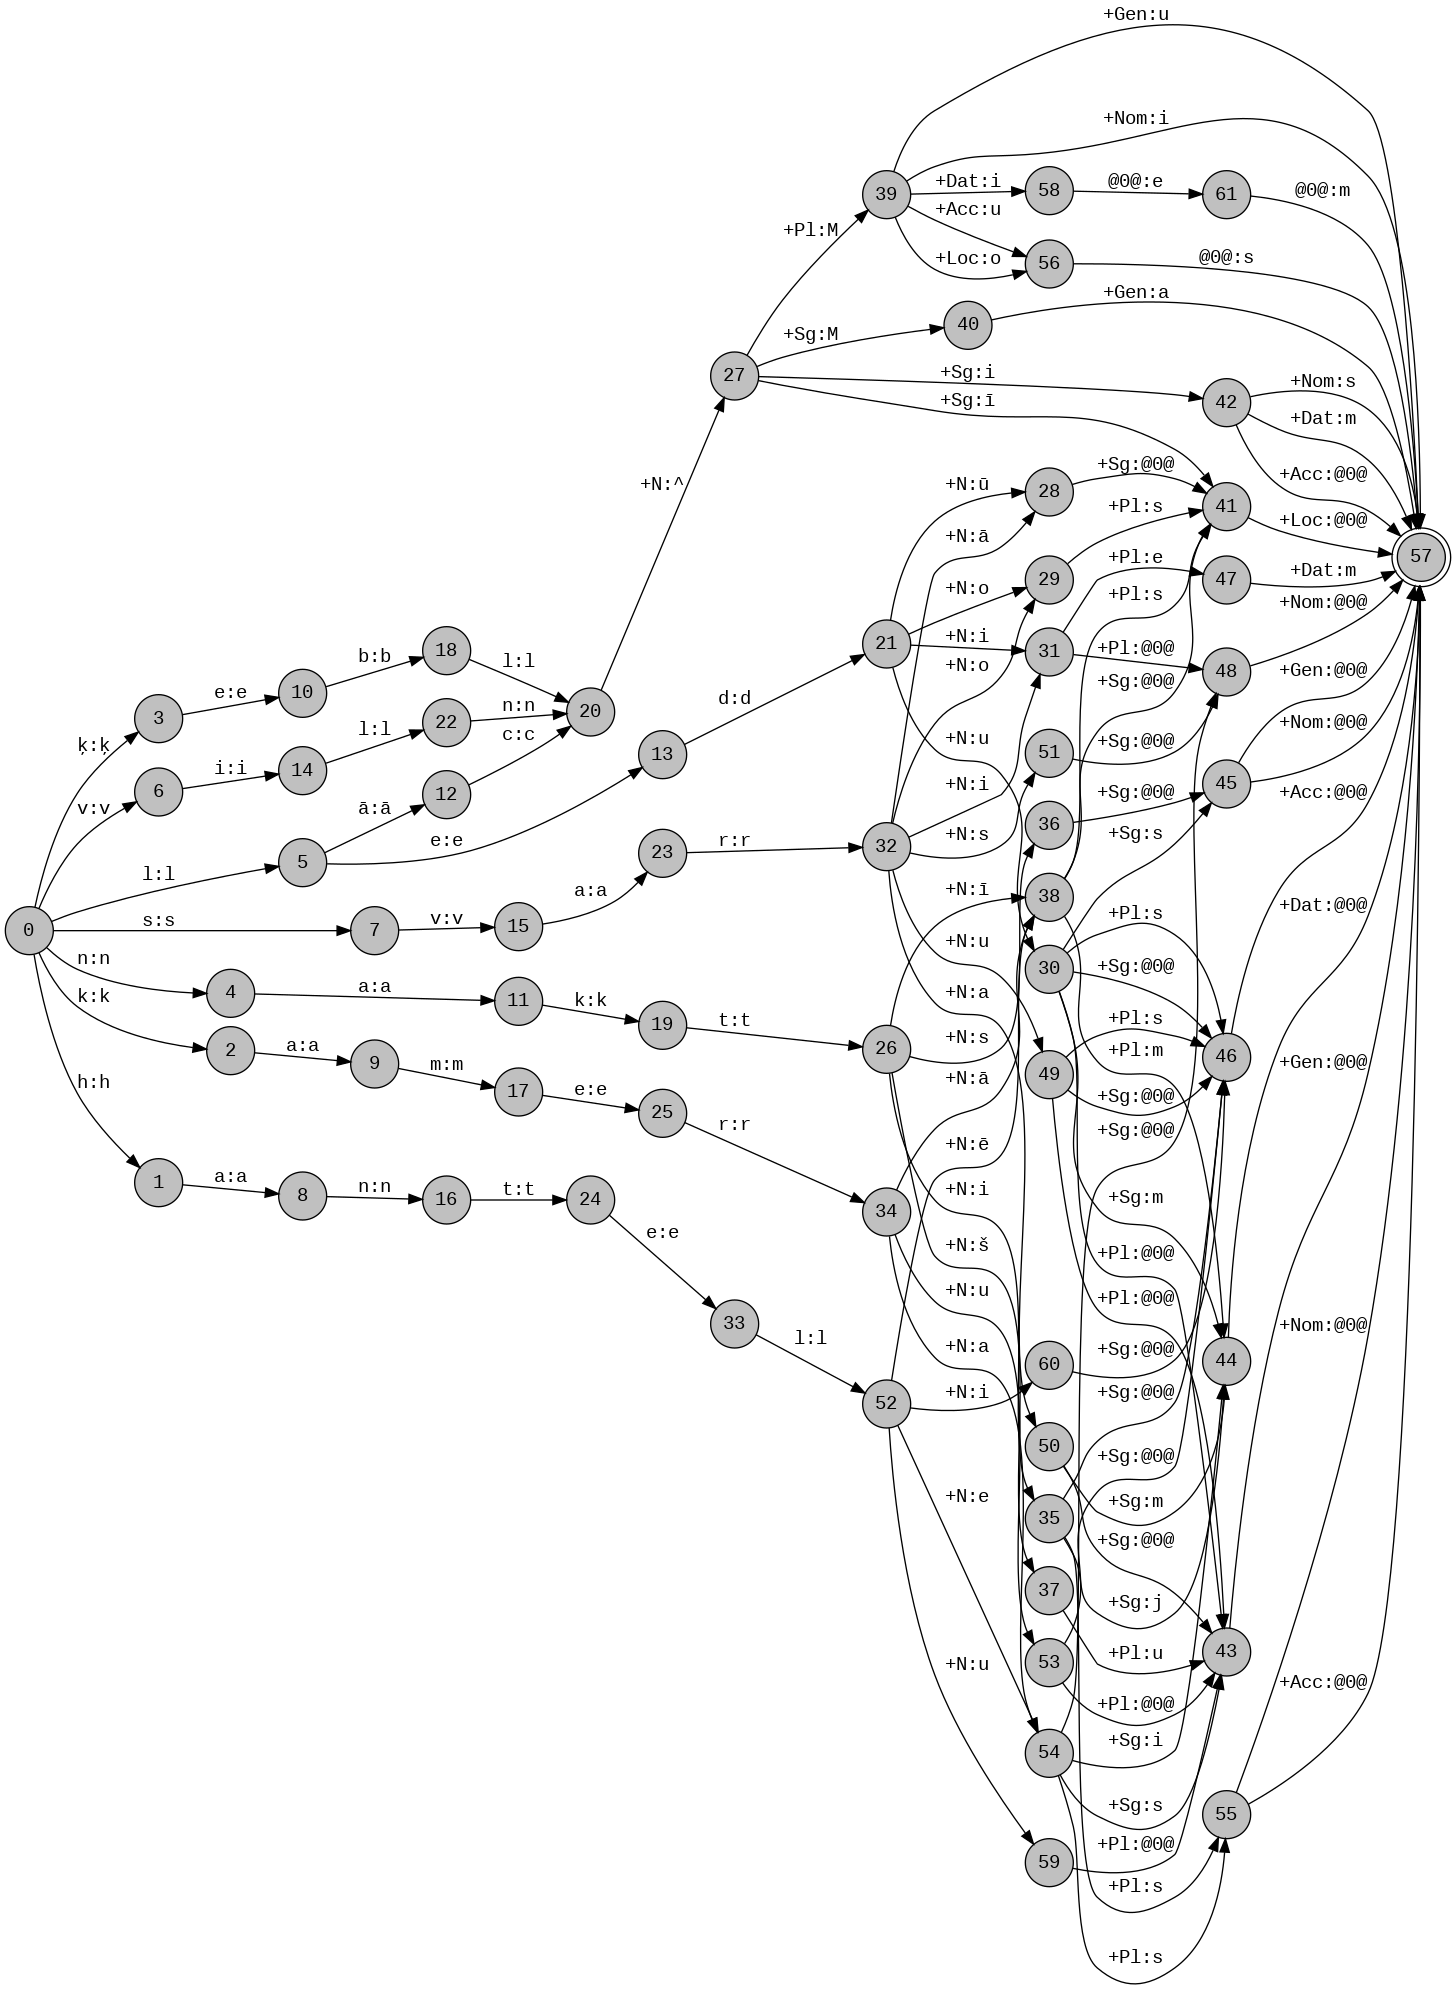

In [ ]:
from hfst import compile_lexc_file
generator = hfst.compile_lexc_file('lexicon.lexc')

# Vizualizācija
hfst2png(generator,'generator.png')
Image('generator.png')

In [ ]:
from hfst import regex, HfstTransducer

### Iespraušana

In [ ]:
# Insertion
InsertJ = hfst.regex('[..] -> j || [b | f | m | p | v] _ "^" M')
print(InsertJ.lookup("ķirb^Ma'"))

(("ķirbj^Ma'", 0.0),)


### Aizstāšana

In [ ]:
# Replacement
CReplacement = hfst.regex('c -> č ||  _ "^" M')
ln_replacement = hfst.regex('l n -> ļ ņ ||  _ "^" M')
print(CReplacement.lookup("lāc^Ma'"))
print(ln_replacement.lookup("viln^Ma'"))

(("lāč^Ma'", 0.0),)
(("viļņ^Ma'", 0.0),)


### Izņēmumi

In [ ]:
# Exceptions
#Exceptions = hfst.regex('[[{puik} "+N" "+Sg" "+Dat" .x. {puikam}] ]')
Exceptions = hfst.regex('a i-> a m || p u i k "^"  _')
print(Exceptions.lookup("puik^ai"))

(('puik^am', 0.0),)


### Dzēšana

In [ ]:
# Deleting
MCleanup = hfst.regex('M -> 0')
Cleanup = hfst.regex('"^" -> 0')
print(MCleanup.lookup("lāč^Ma'"))

(("lāč^@_EPSILON_SYMBOL_@a'", 0.0),)


## FST apvienošana | FST composition

In [ ]:
from hfst import compose

# Sintēze | Generation
cascade = compose((generator, InsertJ, CReplacement,ln_replacement, Exceptions, MCleanup, Cleanup))

In [ ]:
# Analīze | Analysis
inv = hfst.HfstTransducer(cascade)
inv.invert()
inv.convert(hfst.ImplementationType.HFST_OL_TYPE)
print(inv.lookup("svars"))
print(inv.lookup("vilna"))

(('svar+N+Sg+Nom', 0.0),)
()


## FST vizualizācija | FST visualization

In [ ]:
# Call the transformation to png on the HFSTTransducer "cascade"
hfst2png(cascade,'image.png')

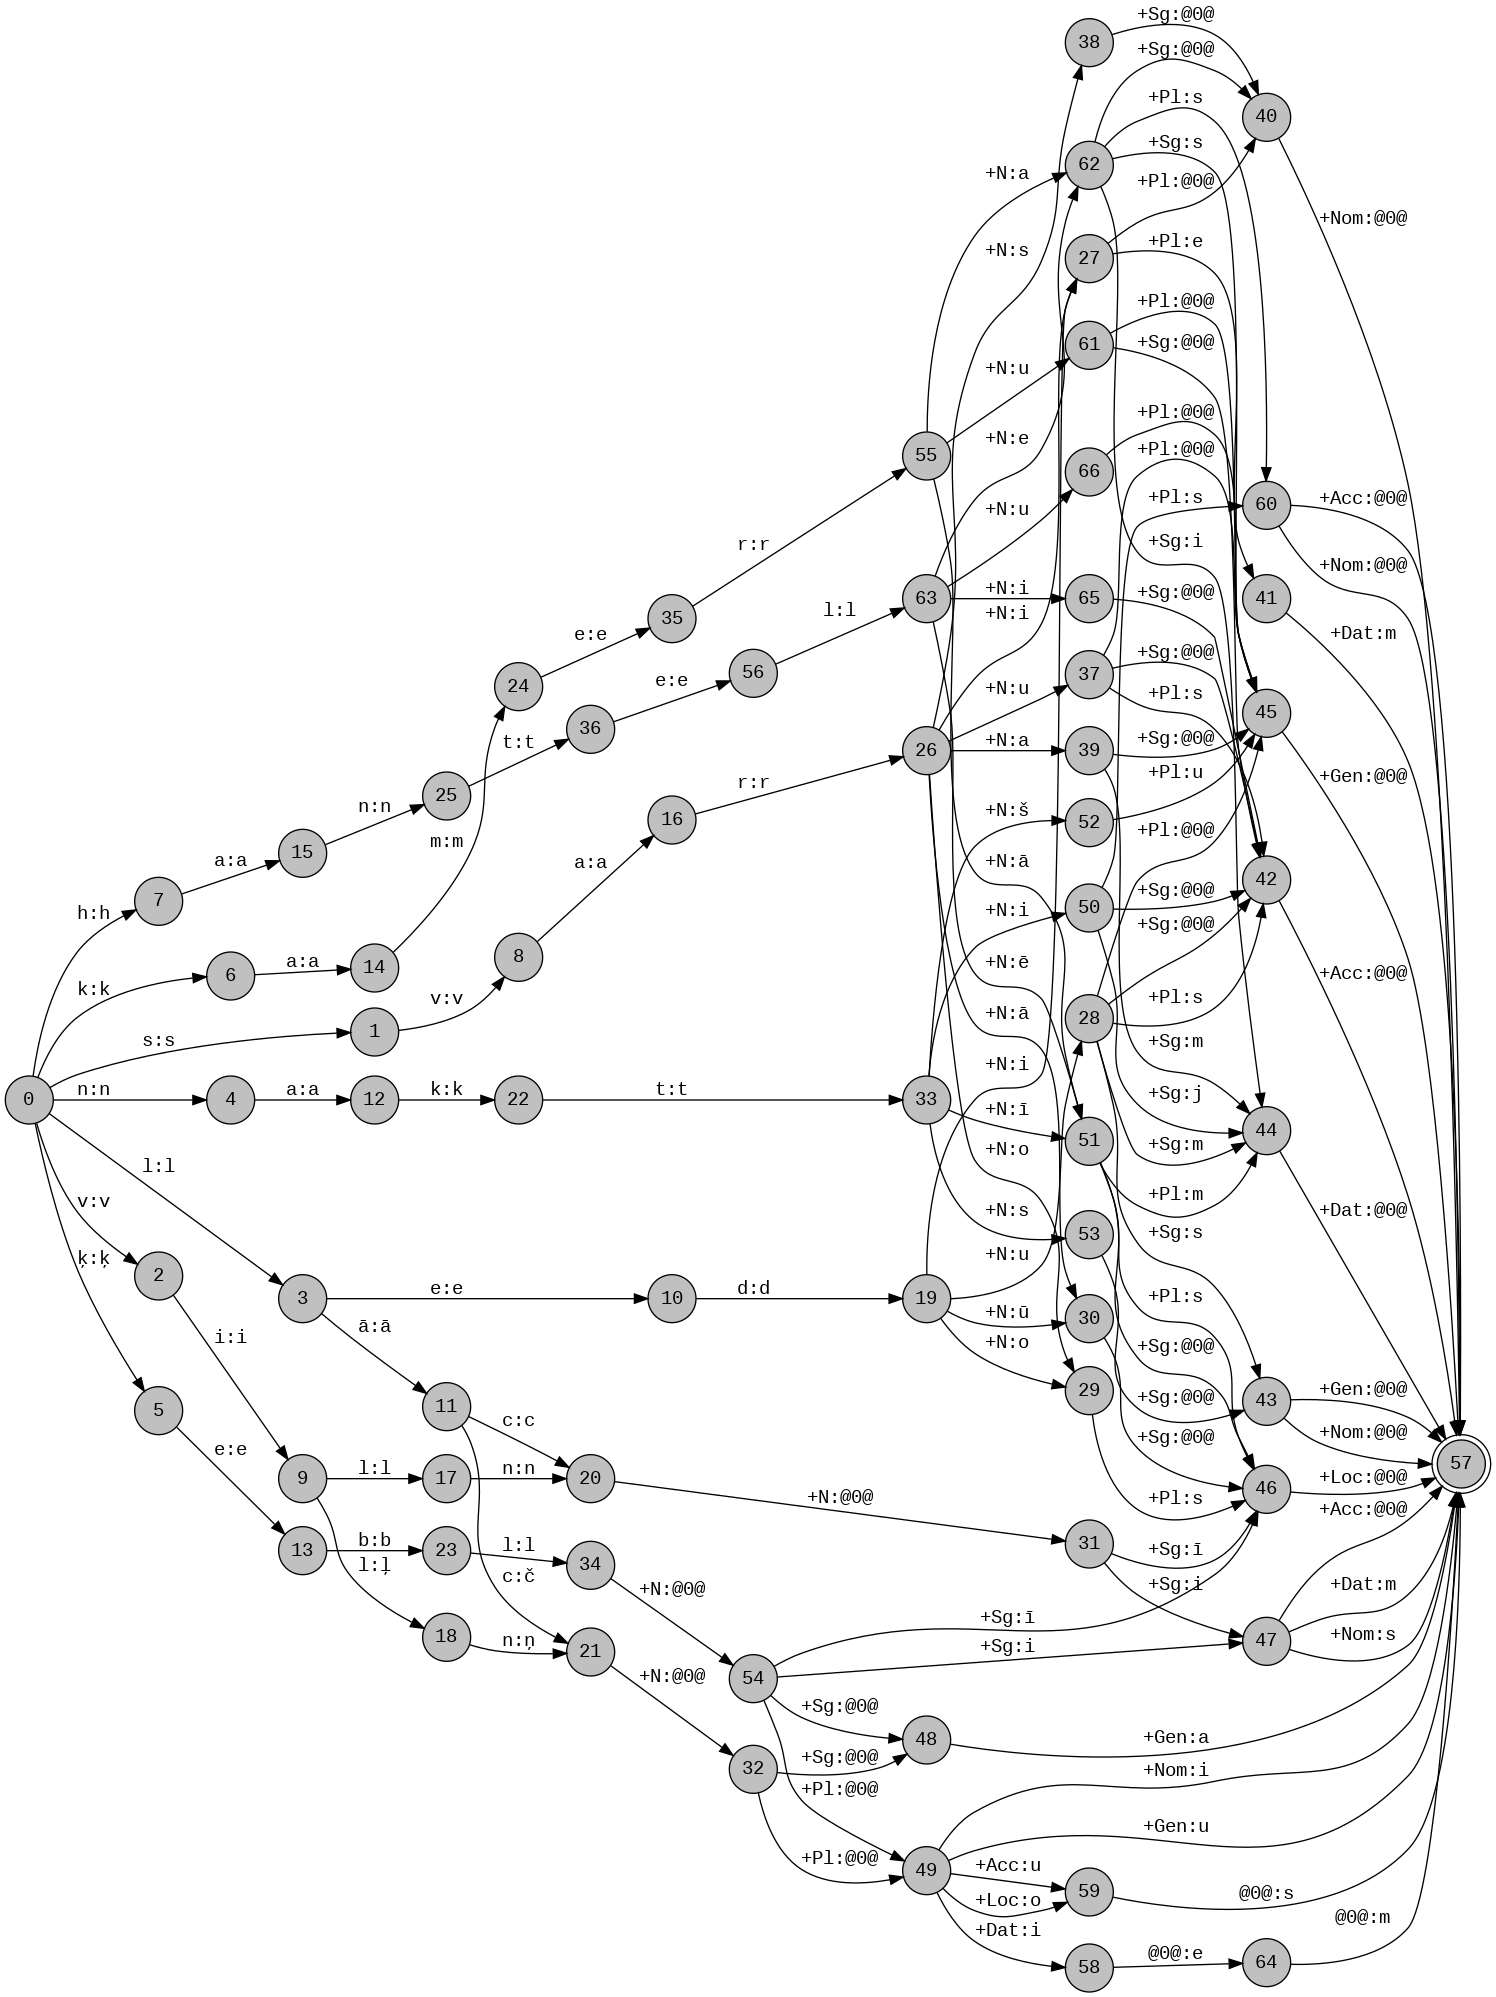

In [ ]:
# Display image in notebook
# from IPython.display import Image
Image('image.png')

Izdrukāšana

In [ ]:
for noun in ["svar", "ķebl", "viln", "led", "lāc", "kamer", "hantel", "nakt"]:
    for number in ["Sg", "Pl"]:
        for form in ["Nom", "Gen", "Dat", "Acc", "Loc"]:
            lookup_results = cascade.lookup(noun + "+N+" + number + "+" + form)
            if lookup_results:
                result = lookup_results[0][0].replace("@_EPSILON_SYMBOL_@", "")
                print(f"{noun}+N+{number}+{form} - {result}")
            else:
                print(f"{noun}+N+{number}+{form} - NO MATCH")

svar+N+Sg+Nom - svars
svar+N+Sg+Gen - svara
svar+N+Sg+Dat - svaram
svar+N+Sg+Acc - svaru
svar+N+Sg+Loc - svarā
svar+N+Pl+Nom - svari
svar+N+Pl+Gen - svaru
svar+N+Pl+Dat - svariem
svar+N+Pl+Acc - svarus
svar+N+Pl+Loc - svaros
ķebl+N+Sg+Nom - ķeblis
ķebl+N+Sg+Gen - ķebla
ķebl+N+Sg+Dat - ķeblim
ķebl+N+Sg+Acc - ķebli
ķebl+N+Sg+Loc - ķeblī
ķebl+N+Pl+Nom - ķebli
ķebl+N+Pl+Gen - ķeblu
ķebl+N+Pl+Dat - ķebliem
ķebl+N+Pl+Acc - ķeblus
ķebl+N+Pl+Loc - ķeblos
viln+N+Sg+Nom - vilnis
viln+N+Sg+Gen - viļņa
viln+N+Sg+Dat - vilnim
viln+N+Sg+Acc - vilni
viln+N+Sg+Loc - vilnī
viln+N+Pl+Nom - viļņi
viln+N+Pl+Gen - viļņu
viln+N+Pl+Dat - viļņiem
viln+N+Pl+Acc - viļņus
viln+N+Pl+Loc - viļņos
led+N+Sg+Nom - ledus
led+N+Sg+Gen - ledus
led+N+Sg+Dat - ledum
led+N+Sg+Acc - ledu
led+N+Sg+Loc - ledū
led+N+Pl+Nom - ledi
led+N+Pl+Gen - ledu
led+N+Pl+Dat - lediem
led+N+Pl+Acc - ledus
led+N+Pl+Loc - ledos
lāc+N+Sg+Nom - lācis
lāc+N+Sg+Gen - lāča
lāc+N+Sg+Dat - lācim
lāc+N+Sg+Acc - lāci
lāc+N+Sg+Loc - lācī
lāc+N+Pl+Nom -